# Granger Causality 테스트 + VAR 모델을 이용한 Tesla 주가 예측 코드

📌 Granger Causality 테스트를 활용한 Tesla 주가 예측 방법  
1️⃣ Granger Causality 테스트 활용  
Granger Causality를 통해 Tesla 주가(종가)와 다른 변수(거래량, 시장 지수 등) 사이의 관계를 검정합니다.  
만약 특정 변수가 Tesla 주가를 Granger Causality 관계로 설명할 수 있다면, 해당 변수를 예측 모델의 피처(feature) 로 포함하여 예측 성능을 향상할 수 있습니다.  

2️⃣ VAR(Vector Autoregression) 모델을 활용한 예측  
Granger Causality 테스트를 통해 의미 있는 관계가 확인된 변수를 활용하여 VAR(벡터 자기회귀) 모델을 적용해 주가를 예측합니다.

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ Granger Causality Test (Tesla Close Price vs Volume)

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6946  , p=0.1013  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=2.7109  , p=0.0997  , df=1
likelihood ratio test: chi2=2.7036  , p=0.1001  , df=1
parameter F test:         F=2.6946  , p=0.1013  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6635  , p=0.1905  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=3.3608  , p=0.1863  , df=2
likelihood ratio test: chi2=3.3495  , p=0.1874  , df=2
parameter F test:         F=1.6635  , p=0.1905  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0256  , p=0.3809  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=3.1209  , p=0.3734  , df=3
likelihood ratio test: chi2=3.1111  , p=0.3748  , df=3
parameter F test:         F=1.0256  , p=0.3809  , df_denom=490, df_num=3

Granger Causality
number of lags (no z

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ 최적의 차수 (p): 10
📌 Test MSE: 507.7535


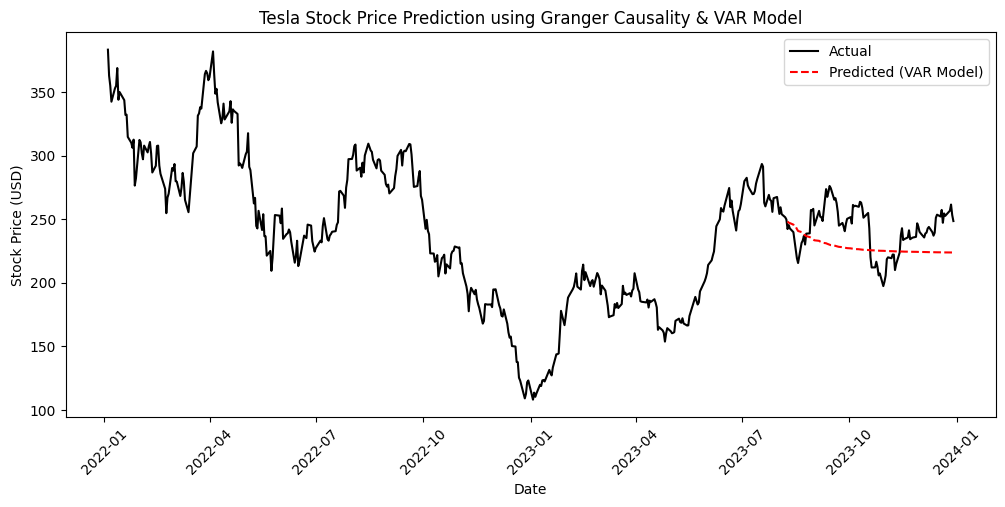

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import mean_squared_error

# ✅ 1️⃣ 테슬라(TSLA) 주가 데이터 다운로드 (최근 2년치)
df = yf.download("TSLA", start="2022-01-01", end="2024-01-01")

# ✅ 2️⃣ 데이터 전처리 및 Feature 생성
df = df.reset_index()
df["Date"] = pd.to_datetime(df["Date"])  # 날짜 변환
df["Return"] = df["Close"].pct_change()  # 수익률 계산
df["Log_Close"] = np.log(df["Close"].replace(0, np.nan))  # 로그 변환 종가
df["Log_Volume"] = np.log(df["Volume"].replace(0, np.nan))  # 로그 변환 거래량
df = df.dropna().reset_index(drop=True)  # 결측값 제거 및 인덱스 리셋

# ✅ 3️⃣ Granger Causality Test (주가 vs 거래량)
max_lag = 10  # 최대 시차 설정
print("✅ Granger Causality Test (Tesla Close Price vs Volume)")
grangercausalitytests(df[["Log_Close", "Log_Volume"]], max_lag, verbose=True)

# ✅ 4️⃣ 변수 선택 (Granger Causality를 통해 유의미한 변수 포함)
data = df[["Date", "Log_Close", "Log_Volume"]].set_index("Date")

# ✅ 5️⃣ 학습 및 테스트 데이터 분할 (80% 학습, 20% 테스트)
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size].copy(), data.iloc[train_size:].copy()

# ✅ 6️⃣ 최적의 VAR 차수(p) 선택 (AIC 기준)
lag_selection = VAR(train)
lag_results = lag_selection.select_order(maxlags=10)
best_lag = lag_results.aic  # AIC 최소값을 갖는 차수 선택
best_lag = max(best_lag, 1)  # ✅ 최소 1 이상 유지
print(f"✅ 최적의 차수 (p): {best_lag}")

# ✅ 7️⃣ VAR 모델 학습
model = VAR(train)
model_fit = model.fit(best_lag)

# ✅ 8️⃣ 예측 수행 (테스트 데이터 크기만큼 예측)
test_pred = model_fit.forecast(train.values[-best_lag:], steps=len(test))

# ✅ 9️⃣ 예측된 결과를 데이터프레임으로 변환
test_pred_df = pd.DataFrame(test_pred, index=test.index, columns=["Log_Close_Pred", "Log_Volume_Pred"])

# ✅ 🔟 로그 변환 해제
test_pred_df["Close_Pred"] = np.exp(test_pred_df["Log_Close_Pred"])

# ✅ 11️⃣ 성능 평가 (MSE)
test_mse = mean_squared_error(np.exp(test["Log_Close"]), test_pred_df["Close_Pred"])
print(f"📌 Test MSE: {test_mse:.4f}")

# ✅ 12️⃣ 결과 시각화 (실제 vs 예측 종가)
plt.figure(figsize=(12, 5))
plt.plot(df["Date"], df["Close"], label="Actual", color="black")
plt.plot(test_pred_df.index, test_pred_df["Close_Pred"], label="Predicted (VAR Model)", linestyle="--", color="red")
plt.title("Tesla Stock Price Prediction using Granger Causality & VAR Model")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.xticks(rotation=45)
plt.legend()
plt.show()
